<a href="https://colab.research.google.com/github/anish-sk/CS6910_Assignment1/blob/master/src/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade wandb
!wandb login 6746f968d95eb71e281d6c7772a0469574430408

     |████████████████████████████████| 2.0MB 5.8MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 133kB 40.6MB/s 
     |████████████████████████████████| 163kB 42.9MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=fceb098eed968353fb5eb69b8aaa38df6f0a7c98d32e463548f275342c2a670e
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=e0b9e49cb64924270489c2d3af8924d3b44601f6d388fabdbab9b1f367e079b3
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Init wandb
import wandb

# run = wandb.init(project="assignment1", entity="abisheks", reinit=True)

import numpy as np
import math
from matplotlib import pyplot as plt
# Loading the fashion mnist dataset
from keras.datasets import fashion_mnist
# Setting seed value
np.random.seed(1)

# Load dataset (train data and test data)
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

4423680/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [ ]:
# Number of classes in the Fashion-MNIST dataset
N_CLASSES = np.unique(trainy).shape[0]    # 10 as known from the keras documentation

# Captions/Labels for the output classes present in Fashion-MNIST dataset
IMG_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def getSampleImages(nClass, imgLabels, X, y, nSamples):
  '''
  The function takes few samples of each class from the dataset provided and passes it to the WANDB for it log the images

  Arguments :
    nClass -- Number of output classes in the dataset
    imgLabels -- List of labels for the output classes (numbered from 0 to nClass - 1)
    X -- The input data containing images in the form of matrices
    y -- The output data containing the class to which an input belongs
    nSamples -- Number of samples of each class to be taken. If that many samples not present in dataset, maximum number of samples present (from that class) will be taken

  Returns :
    -- None --
  '''

  # Initialise empty list to store the input data sampled from each class
  sampleImgsX = [[] for _ in range(nClass)]

  # Take 3 sample images from each class
  for i in range(y.shape[0]):
    if len(sampleImgsX[y[i]]) < nSamples :
      sampleImgsX[y[i]].append(X[i])


  # Getting a list of sample images of each class to be saved to wandb
  sampleImgsList = []
  for i in range(nClass):
    for j in range(3):
      sampleImgsList.append(wandb.Image(sampleImgsX[i][j], caption = imgLabels[i]))

  np.random.shuffle(sampleImgsList)
  wandb.log({"example" : sampleImgsList})


# Question 1 : Show 3 sample images from training set of downloaded Fashion-MNIST dataset in WANDB
# getSampleImages(N_CLASSES, IMG_LABELS, trainX, trainy, 3)
# run.finish()

In [ ]:
def relu(x):
  # Calculates the Rectified Linear Unit (ReLU) function
  return np.maximum(x,0)

def sigmoid(x):
  # Calculates the sigmoid function
  return np.exp(-np.logaddexp(0, -x))

def softmax(x):
  # Calculates the softmax function
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum()

def tanh(x):
  return np.tanh(x)

def linear(W, x, b):
  # Calculates the linear function
  return W @ x + b

def grad_relu(x):
  # Calculates the gradient of Rectified Linear Unit (ReLU) function
  return x > 0

def grad_sigmoid(x):
  # Calculates the gradient of sigmoid function
  return sigmoid(x) * (1 - sigmoid(x))

def grad_tanh(x):
  # Calculates the gradient of tanh function
  return 1 - np.tanh(x)**2

def Softmax_CrossEntropy_grad(y_pred, y):
  # Calculates the gradient of the output layer with softmax activation and cross entropy loss
  # layer -- The dictionary for the output layer contianing info about it
  # y -- True output
  return -(y - y_pred)

In [ ]:
def random_initialisation(shape):
  # Initialising a random matrix with given dimensions (shape) as tuple
  return np.random.randn(*shape)*0.1

def xavier_initialisation(shape):
  # Initialising a matrix by xavier initialisation with given dimensions (shape) as tuple
  bound = (6/(shape[0]+shape[1]))**(0.5)
  return bound*(2*np.random.rand(*shape)-1)

In [ ]:
perm = np.random.permutation(trainX.shape[0])
train_size = int(0.9* len(perm))
train_indices = perm[:train_size]
valid_indices = perm[train_size:]
trainX_reshaped = trainX.reshape(trainX.shape[0], (trainX.shape[1]*trainX.shape[2])) / 255  # Input Training data with ith column being ith training example's data
validX_reshaped = trainX_reshaped[valid_indices]
validy = trainy[valid_indices]
trainX_reshaped = trainX_reshaped[train_indices]
trainy = trainy[train_indices]
testX_reshaped = testX.reshape(testX.shape[0], (testX.shape[1]*testX.shape[2])) / 255       # Input Training data with ith column being ith training example's data

def initialize_network(n_L, preActFns_L, actFns_L, gradActFns_L, gradOutputFn, weight_initialisation):
  '''
  The function initializes the neural network and the appropriate parameters
  
  Arguments :
    n_L -- an array whose ith element represents the number of neurons in the ith layer (0 - Input Layer, last element - Output Layer)
    preActFns_L -- an array who ith element is the Pre Activation function of the (i+1)th layer of the neural network
    actFns_L -- an array who ith element is the Activation function of the (i+1)th layer of the neural network
    gradActFns_L -- an array who ith element is the gradient of the Activation function of the (i+1)th layer of the neural network
    gradOutputFn -- Function to calculate gradients wrt a_L (output layer) in back-propagation
    weight_initialisation -- Function to initialise weights of the layers
  
  Returns :
    network -- the initialized network as an array of dictionaries for the hidden and output layers of the neural network
  '''

  L = len(n_L)-1

  assert(L >= 1)
  assert(len(preActFns_L) == L)
  assert(len(actFns_L) == L)

  network = list()
  for i in range(1,L+1):
    # Dictionary for each layer representing it's constituents
    layer = {'weights':weight_initialisation((n_L[i],n_L[i-1])),  # Weight matrix for (i-1)th to ith layer transition
             'biases':np.zeros((n_L[i],1)),                       # Bias vector for (i-1)th to ith layer transition
             'pre_activation_fn':preActFns_L[i-1],                # Pre-activation function for neurons of the ith layer
             'activation_fn':actFns_L[i-1],                       # Activation function for neurons of the ith layer             
             'no_neurons':n_L[i],                                 # Number of neurons in ith layer
             'cache': []                                          # Array of cached pre-activation and activation output for each layer to be used in back-propagation (will be filled in forward-propagation)
            }
    network.append(layer)	
    if i < L:
      network[-1]['grad_activation_fn'] = gradActFns_L[i-1]       # Function calculating Gradient of the Activation function for the ith (hidden) layer
  
  network[-1]['grad_output_fn'] = gradOutputFn                    # Function calculating Gradient of the Output layer (Gradient of Loss function wrt a_L)

  return network


# wandb.config.update({"n_hidden_layers": 3, "size_hidden_layer":32})    # Setting the hyperparameters in the wandb
# L = wandb.config['n_hidden_layers']+1                                 # Number of hidden layerws + Output layer in the neural network
# n_L = [wandb.config['size_hidden_layer']] * (L+1)                     # List of number of neurons in the neural network

# n_L[0] = trainX.shape[1] * trainX.shape[2]
# n_L[L] = N_CLASSES

# pre_act_fns_L = [linear] * L                  # List of Pre-activation functions of the hidden layers and output layer
# act_fns_L = [sigmoid] * (L-1) + [softmax]     # List of Activation functions of the hidden layers and output layer
# grad_act_fns_L = [grad_sigmoid] * (L-1)       # List of Gradients of the Activation functions, of the hidden layers
# grad_output_fn = Softmax_CrossEntropy_grad

# network = initialize_network(n_L, pre_act_fns_L, act_fns_L, grad_act_fns_L, grad_output_fn, random_initialisation)
# print(network)

In [ ]:
def pre_activation(H_prev, W, b, pre_activation_fn):
  # Calculates the pre-activation output and caches the required values. Returns the output and cache.
  A = pre_activation_fn(W, H_prev, b)
  
  assert(A.shape[0] == W.shape[0])
  pre_act_cache = A   # Caching the pre-activation ouptut to be used in backpropagation

  return A, pre_act_cache

def feedforward_neuron(H_prev, W, b, activation_fn, pre_activation_fn):
  # Calculates the activation output (using the pre-activation function above) and caches the required values. Returns the output and cache.

  H_prev = H_prev.reshape((H_prev.shape[0], 1))
  A, pre_activation_cache = pre_activation(H_prev, W, b, pre_activation_fn)
  H = activation_fn(A)
  
  assert (H.shape[0] == W.shape[0])
  H = H.reshape((H.shape[0],1))
  cache = (pre_activation_cache, H_prev)   # Caching the pre-activation and activation output to use it in back-propagation

  return H, cache

In [ ]:
def forward_propagation(network, x):
    """
    Implement forward propagation for the given neural network
    
    Arguments :
      network -- Given neural network (as an array of dictionaries)
      x -- Input data from the training set
    
    Returns :
      Output from the neural network
    """

    H = x                         # Initialising H to input
    L = len(network)              # Number of (hidden + output) layers in the neural network
    cache_prev = (x,x) 
    for l in range(0, L):
        H_prev = H 
        H, cache = feedforward_neuron(H_prev, network[l]['weights'], network[l]['biases'], network[l]['activation_fn'], network[l]['pre_activation_fn'])
        #network[l]['cache'] = cache_prev
        network[l]['cache'] = cache
        cache_prev = cache
    
    assert(H.shape[0] == (network[L-1]['no_neurons']))
        
    return H

# HL = forward_propagation(trainX_reshaped, network)          # HL -- output from the neural network
# print(HL)

In [ ]:
 def back_propagation(network, y, y_pred, weight_decay):
  """
    Implement backward propagation for the given neural network
    
    Arguments :
      network -- Given neural network (as an array of dictionaries)
      y -- True output corresponding to the training data input
    
    Returns :
      H -- Output from the neural network
  """

  L = len(network)

  # Gradients wrt output layer (a_L)
  grad_a_k_L = network[L-1]['grad_output_fn'](y_pred, y)

  # Initialising gradients to be calculated in the loop below
  grad_w_L = [np.zeros(2)] * L
  grad_b_L = [np.zeros(2)] * L
  grad_h_prev_L, grad_a_prev_L = 0, 0


  for k in range(L-1,-1,-1):
    # Gradients wrt Weights (W_k)
    grad_w_L[k] = grad_a_k_L @ network[k]['cache'][1].T + weight_decay*network[k]['weights']

    # Gradients wrt Biases (b_k)
    grad_b_L[k] = grad_a_k_L

    # Gradients wrt hidden layer
    # Gradients wrt h_(k-1)
    grad_h_prev_L = network[k]['weights'].T @ grad_a_k_L

    # Gradients wrt a_(k-1)
    if(k > 0):
      grad_act_fn_prev = network[k-1]['grad_activation_fn'](network[k-1]['cache'][0])
      grad_a_prev_L = grad_h_prev_L * grad_act_fn_prev

    grad_a_k_L = grad_a_prev_L

  return grad_w_L, grad_b_L

In [ ]:
def CrossEntropy_loss(y_pred, y_true):
  return -(y_true * np.log(y_pred)).sum()

def SquaredError(y_pred, y_true):
  return ((y_true - y_pred) ** 2).sum() / 2.0


In [ ]:
from tqdm import tqdm

def sgd_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, weight_decay=0):
  """
    Trains the neural network using Vanilla/Batch Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith row is the input data corresponding to ith training example
      Y -- True output matrix where ith row is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      
    Returns :
      -- None --
  """
  loss_values = []
  L = len(network)
  M = X.shape[0]
  curr_loss, batch = 0, 0

  dw, db = [0] * L, [0] * L
  for k in range(L):
    dw[k] = np.zeros_like(network[k]['weights'])
    db[k] = np.zeros_like(network[k]['biases'])

  for epoch in tqdm(range(max_epochs)):  

    counter = 0
    for x,y in zip(X, Y):
      counter += 1
      x = x.reshape((x.shape[0], 1))
      y = y.reshape((y.shape[0], 1))
      y_pred = forward_propagation(network, x)
      curr_loss += loss_fn(y_pred, y)
      grad_w_L, grad_b_L = back_propagation(network, y, y_pred, weight_decay)
      for k in range(L):
        dw[k] += grad_w_L[k]
        db[k] += grad_b_L[k]
      
      if counter % batch_size == 0:
        batch += 1
        curr_loss /= batch_size
        loss_values.append(curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
        for k in range(L):
          dw[k] /= batch_size
          db[k] /= batch_size
          network[k]['weights'] -= eta * dw[k]
          network[k]['biases'] -= eta * db[k]
          dw[k] = np.zeros_like(network[k]['weights'])
          db[k] = np.zeros_like(network[k]['biases'])
          curr_loss = 0

    if counter % batch_size != 0:
      batch += 1
      size = counter % batch_size
      curr_loss /= size
      loss_values.append(curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
      for k in range(L):
        dw[k] /= size
        db[k] /= size
        network[k]['weights'] -= eta * dw[k]
        network[k]['biases'] -= eta * db[k]
        dw[k] = np.zeros_like(network[k]['weights'])
        db[k] = np.zeros_like(network[k]['biases'])
  
  return loss_values


In [ ]:
def momentum_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, beta = 0.9, 
                              weight_decay=0):
  """
    Trains the neural network using Momentum Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith row is the input data corresponding to ith training example
      Y -- True output matrix where ith row is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      beta -- Hyperparameter to tune dependency of gradient on history
      
    Returns :
      -- None --
  """
  loss_values = []
  L = len(network)
  M = X.shape[0]
  curr_loss, batch = 0, 0

  dw, db, m_w, m_b = [0] * L, [0] * L, [0] * L, [0] * L
  for k in range(L):
    dw[k] = np.zeros_like(network[k]['weights'])
    db[k] = np.zeros_like(network[k]['biases'])
    m_w[k] = np.zeros_like(network[k]['weights'])
    m_b[k] = np.zeros_like(network[k]['biases'])


  for epoch in tqdm(range(max_epochs)):  

    counter = 0
    for x,y in zip(X, Y):
      counter += 1
      x = x.reshape((x.shape[0], 1))
      y = y.reshape((y.shape[0], 1))
      y_pred = forward_propagation(network, x)
      curr_loss += loss_fn(y_pred, y)
      grad_w_L, grad_b_L = back_propagation(network, y, y_pred, weight_decay)
      for k in range(L):
        dw[k] += grad_w_L[k]
        db[k] += grad_b_L[k]
      
      if counter % batch_size == 0:
        batch += 1
        curr_loss /= batch_size
        loss_values.append(curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
        for k in range(L):
          dw[k] /= batch_size
          db[k] /= batch_size
          m_w[k] = m_w[k] * beta + dw[k] * eta
          m_b[k] = m_b[k] * beta + db[k] * eta
          network[k]['weights'] -= m_w[k]
          network[k]['biases'] -= m_b[k]
          dw[k] = np.zeros_like(network[k]['weights'])
          db[k] = np.zeros_like(network[k]['biases'])
          curr_loss = 0

    if counter % batch_size != 0:
      batch += 1
      size = counter % batch_size
      curr_loss /= size
      loss_values.append(curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
      for k in range(L):
        dw[k] /= size
        db[k] /= size
        m_w[k] = m_w[k] * beta + dw[k] * eta
        m_b[k] = m_b[k] * beta + db[k] * eta
        network[k]['weights'] -= eta * dw[k]
        network[k]['biases'] -= eta * db[k]
        dw[k] = np.zeros_like(network[k]['weights'])
        db[k] = np.zeros_like(network[k]['biases'])
        curr_loss = 0
  
  return loss_values
  

def nesterov_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, beta = 0.9, 
                              weight_decay=0):
  """
    Trains the neural network using Nesterov Accelerated Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith row is the input data corresponding to ith training example
      Y -- True output matrix where ith row is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      beta -- Hyperparameter to tune dependency of gradient on history
      
    Returns :
      -- None --
  """
  loss_values = []
  L = len(network)
  M = X.shape[0]
  curr_loss, batch = 0, 0

  dw, db, m_w, m_b = [0] * L, [0] * L, [0] * L, [0] * L
  for k in range(L):
    dw[k] = np.zeros_like(network[k]['weights'])
    db[k] = np.zeros_like(network[k]['biases'])
    m_w[k] = np.zeros_like(network[k]['weights'])
    m_b[k] = np.zeros_like(network[k]['biases'])

  lookahead_network = network[:]

  for epoch in tqdm(range(max_epochs)):

    counter = 0
    for x,y in zip(X, Y):
      counter += 1
      x = x.reshape((x.shape[0], 1))
      y = y.reshape((y.shape[0], 1))
      y_pred_org = forward_propagation(network, x)
      curr_loss += loss_fn(y_pred_org, y)
      y_pred = forward_propagation(lookahead_network, x)
      grad_w_L, grad_b_L = back_propagation(lookahead_network, y, y_pred, weight_decay)
      for k in range(L):
        dw[k] += grad_w_L[k]
        db[k] += grad_b_L[k]
      
      if counter % batch_size == 0:
        batch += 1
        curr_loss /= batch_size
        loss_values.append(curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
        for k in range(L):
          dw[k] /= batch_size
          db[k] /= batch_size
          m_w[k] = m_w[k] * beta + dw[k] * eta
          m_b[k] = m_b[k] * beta + db[k] * eta
          network[k]['weights'] -= m_w[k]
          network[k]['biases'] -= m_b[k] 
          lookahead_network[k]['weights'] -= (eta * dw[k] + beta * m_w[k])
          lookahead_network[k]['biases'] -= (eta * db[k] + beta * m_b[k])
          dw[k] = np.zeros_like(network[k]['weights'])
          db[k] = np.zeros_like(network[k]['biases'])
          curr_loss = 0

    if counter % batch_size != 0:
      batch += 1
      size = counter % batch_size
      curr_loss /= size
      loss_values.append(curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
      for k in range(L):
        dw[k] /= size
        db[k] /= size
        m_w[k] = m_w[k] * beta + dw[k] * eta
        m_b[k] = m_b[k] * beta + db[k] * eta
        network[k]['weights'] -= m_w[k]
        network[k]['biases'] -= m_b[k]
        lookahead_network[k]['weights'] -= (eta * dw[k] + beta * m_w[k])
        lookahead_network[k]['biases'] -= (eta * db[k] + beta * m_b[k])
        dw[k] = np.zeros_like(network[k]['weights'])
        db[k] = np.zeros_like(network[k]['biases'])
        curr_loss = 0

  return loss_values


In [ ]:
def rmsprop_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, eps = 1e-8, beta = 0.9,
                             weight_decay=0):
  """
    Trains the neural network using RMSProp Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith row is the input data corresponding to ith training example
      Y -- True output matrix where ith row is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      eps -- Epsilon hyperparameter
      beta -- Hyperparameter acting as decaying weight for learning rate update
      
    Returns :
      -- None --
  """
  loss_values = []
  L = len(network)
  M = X.shape[0]
  curr_loss, batch = 0, 0

  dw, db, v_w, v_b = [0] * L, [0] * L, [0] * L, [0] * L
  for k in range(L):
    dw[k] = np.zeros_like(network[k]['weights'])
    db[k] = np.zeros_like(network[k]['biases'])
    v_w[k] = np.zeros_like(network[k]['weights'])
    v_b[k] = np.zeros_like(network[k]['biases'])

  for epoch in tqdm(range(max_epochs)):  

    counter = 0
    for x,y in zip(X, Y):
      counter += 1
      x = x.reshape((x.shape[0], 1))
      y = y.reshape((y.shape[0], 1))
      y_pred = forward_propagation(network, x)
      curr_loss += loss_fn(y_pred, y)
      grad_w_L, grad_b_L = back_propagation(network, y, y_pred, weight_decay)
      for k in range(L):
        dw[k] += grad_w_L[k]
        db[k] += grad_b_L[k]
      
      if counter % batch_size == 0:
        batch += 1
        curr_loss /= batch_size
        loss_values.append(curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
        for k in range(L):
          dw[k] /= batch_size
          db[k] /= batch_size
          v_w[k] = v_w[k] * beta + (1-beta) * dw[k]**2
          v_b[k] = v_b[k] * beta + (1-beta) * db[k]**2
          network[k]['weights'] -= (eta / np.sqrt(v_w[k] + eps)) * dw[k]
          network[k]['biases'] -= (eta / np.sqrt(v_b[k] + eps)) * db[k]
          dw[k] = np.zeros_like(network[k]['weights'])
          db[k] = np.zeros_like(network[k]['biases'])
          curr_loss = 0

    if counter % batch_size != 0:
      batch += 1
      size = counter % batch_size
      curr_loss /= size
      loss_values.append(curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
      for k in range(L):
        dw[k] /= size
        db[k] /= size
        v_w[k] = v_w[k] * beta + (1-beta) * dw[k]**2
        v_b[k] = v_b[k] * beta + (1-beta) * db[k]**2
        network[k]['weights'] -= (eta / np.sqrt(v_w[k] + eps)) * dw[k]
        network[k]['biases'] -= (eta / np.sqrt(v_b[k] + eps)) * db[k]
        dw[k] = np.zeros_like(network[k]['weights'])
        db[k] = np.zeros_like(network[k]['biases'])
        curr_loss = 0
  
  return loss_values
  

In [ ]:
def adam_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 50, loss_fn = CrossEntropy_loss, eps = 1e-8, beta1 = 0.9, 
                          beta2 = 0.999, weight_decay=0):
  """
    Trains the neural network using Adam Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith row is the input data corresponding to ith training example
      Y -- True output matrix where ith row is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      eps -- Epsilon hyperparameter
      beta1 -- Hyperparameter acting as decaying weight for momentum update
      beta2 -- Hyperparameter acting as decaying weight for learning rate update
      
    Returns :
      -- None --
  """
  loss_values = []
  L = len(network)
  M = X.shape[0]
  curr_loss, batch = 0, 0

  dw, db, m_w, m_b, v_w, v_b = [0] * L, [0] * L, [0] * L, [0] * L, [0] * L, [0] * L
  for k in range(L):
    dw[k] = np.zeros_like(network[k]['weights'])
    db[k] = np.zeros_like(network[k]['biases'])
    m_w[k] = np.zeros_like(network[k]['weights'])
    m_b[k] = np.zeros_like(network[k]['biases'])
    v_w[k] = np.zeros_like(network[k]['weights'])
    v_b[k] = np.zeros_like(network[k]['biases'])


  for epoch in tqdm(range(max_epochs)):  

    counter = 0
    for x,y in zip(X, Y):
      counter += 1
      x = x.reshape((x.shape[0], 1))
      y = y.reshape((y.shape[0], 1))
      y_pred = forward_propagation(network, x)
      curr_loss += loss_fn(y_pred, y)
      grad_w_L, grad_b_L = back_propagation(network, y, y_pred, weight_decay)
      for k in range(L):
        dw[k] += grad_w_L[k]
        db[k] += grad_b_L[k]
      
      if counter % batch_size == 0:
        batch += 1
        curr_loss /= batch_size
        loss_values.append(curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
        for k in range(L):
          dw[k] /= batch_size
          db[k] /= batch_size
          m_w[k] = m_w[k] * beta1 + (1-beta1) * dw[k]
          m_b[k] = m_b[k] * beta1 + (1-beta1) * db[k]
          v_w[k] = v_w[k] * beta2 + (1-beta2) * dw[k]**2
          v_b[k] = v_b[k] * beta2 + (1-beta2) * db[k]**2
          m_w_hat = m_w[k] / (1 - math.pow(beta1, batch))
          m_b_hat = m_b[k] / (1 - math.pow(beta1, batch))
          v_w_hat = v_w[k] / (1 - math.pow(beta2, batch))
          v_b_hat = v_b[k] / (1 - math.pow(beta2, batch))
          network[k]['weights'] -= (eta / np.sqrt(v_w_hat + eps)) * m_w_hat
          network[k]['biases'] -= (eta / np.sqrt(v_b_hat + eps)) * m_b_hat
          dw[k] = np.zeros_like(network[k]['weights'])
          db[k] = np.zeros_like(network[k]['biases'])
          curr_loss = 0

    if counter % batch_size != 0:
      batch += 1
      size = counter % batch_size
      curr_loss /= size
      loss_values.append(curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
      for k in range(L):
        dw[k] /= size
        db[k] /= size
        m_w[k] = m_w[k] * beta1 + (1-beta1) * dw[k]
        m_b[k] = m_b[k] * beta1 + (1-beta1) * db[k]
        v_w[k] = v_w[k] * beta2 + (1-beta2) * dw[k]**2
        v_b[k] = v_b[k] * beta2 + (1-beta2) * db[k]**2
        m_w_hat = m_w[k] / (1 - math.pow(beta1, batch))
        m_b_hat = m_b[k] / (1 - math.pow(beta1, batch))
        v_w_hat = v_w[k] / (1 - math.pow(beta2, batch))
        v_b_hat = v_b[k] / (1 - math.pow(beta2, batch))
        network[k]['weights'] -= (eta / np.sqrt(v_w_hat + eps)) * m_w_hat
        network[k]['biases'] -= (eta / np.sqrt(v_b_hat + eps)) * m_b_hat
        dw[k] = np.zeros_like(network[k]['weights'])
        db[k] = np.zeros_like(network[k]['biases'])
        curr_loss = 0

  return loss_values
  

In [ ]:
# Nadam optimisation followed from this paper : https://arxiv.org/pdf/1609.04747.pdf
def nadam_gradient_descent(X, Y, network, batch_size = 1, eta = 5e-2, max_epochs = 100, loss_fn = CrossEntropy_loss, eps = 1e-8, beta1 = 0.9, 
                           beta2 = 0.999, weight_decay=0):
  """
    Trains the neural network using Nadam Accelerated Gradient Descent
    
    Arguments :
      X -- Input data matrix where ith row is the input data corresponding to ith training example
      Y -- True output matrix where ith row is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      eps -- Epsilon hyperparameter
      beta1 -- Hyperparameter acting as decaying weight for momentum update
      beta2 -- Hyperparameter acting as decaying weight for learning rate update
      
    Returns :
      -- None --
  """
  loss_values = []
  L = len(network)
  M = X.shape[0]
  curr_loss, batch = 0, 0

  dw, db, m_w, m_b, v_w, v_b = [0] * L, [0] * L, [0] * L, [0] * L, [0] * L, [0] * L
  for k in range(L):
    dw[k] = np.zeros_like(network[k]['weights'])
    db[k] = np.zeros_like(network[k]['biases'])
    m_w[k] = np.zeros_like(network[k]['weights'])
    m_b[k] = np.zeros_like(network[k]['biases'])
    v_w[k] = np.zeros_like(network[k]['weights'])
    v_b[k] = np.zeros_like(network[k]['biases'])


  for epoch in tqdm(range(max_epochs)):  

    counter = 0
    for x,y in zip(X, Y):
      counter += 1
      x = x.reshape((x.shape[0], 1))
      y = y.reshape((y.shape[0], 1))
      y_pred = forward_propagation(network, x)
      curr_loss += loss_fn(y_pred, y)
      grad_w_L, grad_b_L = back_propagation(network, y, y_pred,weight_decay)
      for k in range(L):
        dw[k] += grad_w_L[k]
        db[k] += grad_b_L[k]
      
      if counter % batch_size == 0:
        batch += 1
        curr_loss /= batch_size
        loss_values.append(curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
        for k in range(L):
          dw[k] /= batch_size
          db[k] /= batch_size
          m_w[k] = m_w[k] * beta1 + (1-beta1) * dw[k]
          m_b[k] = m_b[k] * beta1 + (1-beta1) * db[k]
          v_w[k] = v_w[k] * beta2 + (1-beta2) * dw[k]**2
          v_b[k] = v_b[k] * beta2 + (1-beta2) * db[k]**2
          m_w_hat = m_w[k] / (1 - math.pow(beta1, batch))
          m_b_hat = m_b[k] / (1 - math.pow(beta1, batch))
          v_w_hat = v_w[k] / (1 - math.pow(beta2, batch))
          v_b_hat = v_b[k] / (1 - math.pow(beta2, batch))
          network[k]['weights'] -= (eta / np.sqrt(v_w_hat + eps)) * (m_w_hat + (1-beta1) / (1 - math.pow(beta1, batch)) * dw[k])
          network[k]['biases'] -= (eta / np.sqrt(v_b_hat + eps)) * (m_b_hat + (1-beta1) / (1 - math.pow(beta1, batch)) * db[k])
          dw[k] = np.zeros_like(network[k]['weights'])
          db[k] = np.zeros_like(network[k]['biases'])
          curr_loss = 0

    if counter % batch_size != 0:
      batch += 1
      size = counter % batch_size
      curr_loss /= size
      loss_values.append(curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'loss': curr_loss})
      for k in range(L):
        dw[k] /= size
        db[k] /= size
        m_w[k] = m_w[k] * beta1 + (1-beta1) * dw[k]
        m_b[k] = m_b[k] * beta1 + (1-beta1) * db[k]
        v_w[k] = v_w[k] * beta2 + (1-beta2) * dw[k]**2
        v_b[k] = v_b[k] * beta2 + (1-beta2) * db[k]**2
        m_w_hat = m_w[k] / (1 - math.pow(beta1, batch))
        m_b_hat = m_b[k] / (1 - math.pow(beta1, batch))
        v_w_hat = v_w[k] / (1 - math.pow(beta2, batch))
        v_b_hat = v_b[k] / (1 - math.pow(beta2, batch))
        network[k]['weights'] -= (eta / np.sqrt(v_w_hat + eps)) * (m_w_hat + (1-beta1) / (1 - math.pow(beta1, batch)) * dw[k])
        network[k]['biases'] -= (eta / np.sqrt(v_b_hat + eps)) * (m_b_hat + (1-beta1) / (1 - math.pow(beta1, batch)) * db[k])
        dw[k] = np.zeros_like(network[k]['weights'])
        db[k] = np.zeros_like(network[k]['biases'])
        curr_loss = 0

  return loss_values


In [ ]:
import warnings
warnings.filterwarnings('ignore')

get_grad = {
    'sigmoid' : grad_sigmoid,
    'tanh' : grad_tanh,
    'relu' : grad_relu
}

get_gd_function = {
    'sgd_gradient_descent' : sgd_gradient_descent, 
    'momentum_gradient_descent' : momentum_gradient_descent, 
    'nesterov_gradient_descent' : nesterov_gradient_descent, 
    'rmsprop_gradient_descent' : rmsprop_gradient_descent, 
    'adam_gradient_descent' : adam_gradient_descent, 
    'nadam_gradient_descent' : nadam_gradient_descent 
}

get_activ_fn = {
    'sigmoid' : sigmoid,
    'tanh' : tanh,
    'relu' : relu
}

get_weight_init_fn = {
    'random_initialisation':random_initialisation, 
    'xavier_initialisation':xavier_initialisation
}

def calc_accuracy(network, testX, testY):
  n_correct = 0
  for tx, ty in zip(testX, testY):
    tx = tx.reshape((tx.shape[0], 1))
    testy_pred = np.argmax(forward_propagation(network, tx))
    n_correct += (testy_pred == ty)
  
  acc = n_correct/testX.shape[0]
  return acc


def train_NN(trainX, trainY, validX, validY, optimisation_fn, batch_size, learning_rate, max_epochs, no_hidden_layers, size_hidden_layer, weight_initialisation_fn,
             activation_fn, pre_activation_fn = linear, output_fn = softmax, grad_act_fn = grad_sigmoid, 
             grad_output_fn = Softmax_CrossEntropy_grad, loss_fn = CrossEntropy_loss, weight_decay = 0):
  # Setting the hyperparameters in the wandb
  wandb.config.update({"no_hidden_layers": no_hidden_layers, 
                       "size_hidden_layer": size_hidden_layer,
                       "batch_size": batch_size,
                       "learning_rate": learning_rate,
                       "max_epochs": max_epochs,
                      })
  
  # Converting y labels to onehot representation for training
  trainY_onehot = []
  for y in trainY:
    curr_y = [0]*N_CLASSES
    curr_y[y] = 1
    trainY_onehot.append(curr_y)

  trainY_onehot = np.array(trainY_onehot)
    
  L = no_hidden_layers+1                                # Number of hidden layerws + Output layer in the neural network
  n_L = [size_hidden_layer] * (L+1)                     # List of number of neurons in the neural network

  n_L[0] = trainX.shape[1]
  n_L[L] = trainY_onehot.shape[1]

  pre_act_fns_L = [pre_activation_fn] * L               # List of Pre-activation functions of the hidden layers and output layer
  act_fns_L = [activation_fn] * (L-1) + [output_fn]     # List of Activation functions of the hidden layers and output layer
  grad_act_fns_L = [grad_act_fn] * (L-1)                # List of Gradients of the Activation functions, of the hidden layers


  network = initialize_network(n_L, pre_act_fns_L, act_fns_L, grad_act_fns_L, grad_output_fn, weight_initialisation_fn)
  loss_values = optimisation_fn(trainX, trainY_onehot, network, batch_size, learning_rate, max_epochs, loss_fn)

  plt.plot(loss_values)
  plt.show()  
  valid_acc = calc_accuracy(network, validX, validY)
  wandb.log({'validation_accuracy': valid_acc})

  return network

# run = wandb.init(project="assignment1", entity="abisheks", reinit=True)
# network = train_NN(trainX_reshaped[:5], trainy[:5], validX_reshaped, validy, rmsprop_gradient_descent, 128, 1e-3, 20, 2, 10, random_initialisation, tanh,  linear, softmax, grad_tanh)
# test_acc = calc_accuracy(network, testX_reshaped, testy)
# run.log({'test_accuracy': test_acc})
# run.finish()

# print(f'Training data original output : {trainy_onehot[0]}')
# print(f'Training data output from NN : {forward_propagation(network, trainX_reshaped[0].reshape((trainX_reshaped.shape[1],1))).T}')

In [ ]:
sweep_config = {
    'method': 'random', #grid, random, bayes
    'metric': {
      'name': 'validation_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'max_epochs': {
            'values': [5, 10]
        },
        'no_hidden_layers': {
            'values': [3, 4, 5]
        },
        'size_hidden_layer': {
            'values': [32, 64, 128]
        },
        'weight_decay' :{
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4]
        },
        'optimisation_fn': {
            'values': ['sgd_gradient_descent', 'momentum_gradient_descent', 'nesterov_gradient_descent', 'rmsprop_gradient_descent', 
                       'adam_gradient_descent', 'nadam_gradient_descent' ]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_initialisation_fn': {
            'values': ['random_initialisation', 'xavier_initialisation']
        },
        'activation_fn': {
            'values': ['relu', 'tanh', 'sigmoid']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="abisheks", project="assignment1")

Create sweep with ID: 4ia43v08
Sweep URL: https://wandb.ai/abisheks/assignment1/sweeps/4ia43v08


In [ ]:
def sweep_wrapper():
  # Default values for hyper-parameters we're going to sweep over
  config_defaults =  {
      'max_epochs': 5,
      'no_hidden_layers': 3,
      'size_hidden_layer': 32, 
      'weight_decay' : 0,
      'learning_rate': 1e-2,
      'optimisation_fn': 'sgd_gradient_descent',
      'batch_size': 16,
      'weight_initialisation_fn': 'random_initialisation', 
      'activation_fn': 'relu'
  }

  # Initialize a new wandb run
  run = wandb.init(config=config_defaults, reinit=True)
  
  # Config is a variable that holds and saves hyperparameters and inputs
  config = wandb.config

  train_NN(trainX_reshaped, trainy, validX_reshaped, validy, get_gd_function[config.optimisation_fn], config.batch_size, config.learning_rate, 
           config.max_epochs, config.no_hidden_layers, config.size_hidden_layer, get_weight_init_fn[config.weight_initialisation_fn],
           get_activ_fn[config.activation_fn], linear, softmax, get_grad[config.activation_fn], 
           Softmax_CrossEntropy_grad, CrossEntropy_loss, config.weight_decay)
  
  run.finish()



wandb: Agent Starting Run: miumx7ls with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimisation_fn: sgd_gradient_descent
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation_fn: xavier_initialisation


wandb: WARNING Config item 'no_hidden_layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'size_hidden_layer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
100%|██████████| 5/5 [10:05<00:00, 121.09s/it]


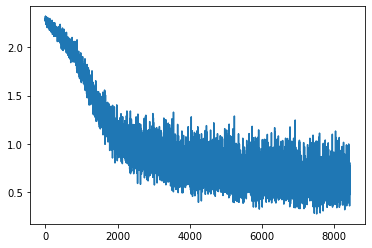

batch,8440
epoch,4
loss,0.5606
_runtime,611
_timestamp,1615231008
_step,8440
validation_accuracy,0.79833


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
loss,████▇▆▆▄▄▄▄▃▃▃▄▃▃▂▃▃▂▂▂▂▂▂▂▁▂▁▂▃▁▃▁▁▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_accuracy,▁


wandb: Agent Starting Run: o1q9fj7w with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.01
wandb: 	max_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimisation_fn: sgd_gradient_descent
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation_fn: xavier_initialisation


wandb: WARNING Config item 'no_hidden_layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'size_hidden_layer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
100%|██████████| 5/5 [10:35<00:00, 127.09s/it]


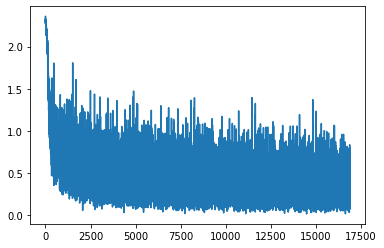

batch,16875
epoch,4
loss,0.27633
_runtime,641
_timestamp,1615231655
_step,16875
validation_accuracy,0.86617


batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
loss,██▄▄▅▃▃▃▃▂▃▂▂▂▂▁▃▃▂▃▃▄▅▄▄▄▃▄▂▃▁▂▄▅▁▁▂▃▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_accuracy,▁


wandb: Agent Starting Run: l74x250c with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.01
wandb: 	max_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimisation_fn: nadam_gradient_descent
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0.5
wandb: 	weight_initialisation_fn: xavier_initialisation


wandb: WARNING Config item 'no_hidden_layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'size_hidden_layer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
 80%|████████  | 4/5 [03:45<00:56, 56.47s/it]

In [ ]:
wandb.agent(sweep_id, sweep_wrapper)